In [1]:
# A class to get the sentences from the dataset
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        aggregate_function = lambda s : [(w, t)
                                         for w, t in zip(s["Word"].values.tolist(),
                                                         s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(aggregate_function)
        self.sentences = [s for s in self.grouped]

    def getNext(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            print("Exception")
            self.empty = True
            return None

In [2]:
import pandas as pd
import numpy as np

# read the annotated dataset from kaggle
data = pd.read_csv("CADEC.csv")
data = data.fillna(method="ffill")
#data.tail(10)

l_words = list(set(data["Word"].values))
n_words = len(l_words)

l_tags = list(set(data["Tag"].values))
n_tags = len(l_tags)

sentence_getter = SentenceGetter(data)
l_sentences = sentence_getter.sentences

# Prepare the data
n_max_seq_size = 75
d_words_to_index = {word: index + 1 for index, word in enumerate(l_words)}
d_tags_to_index = {tag: index for index, tag in enumerate(l_tags)}

In [3]:
# preparing training and test data sets
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X = [[d_words_to_index[word[0]] for word in sentence] for sentence in l_sentences]
X = pad_sequences(maxlen=n_max_seq_size, sequences=X, padding="post", value=n_words-1)

y = [[d_tags_to_index[word[1]] for word in sentence] for sentence in l_sentences]
y = pad_sequences(maxlen=n_max_seq_size, sequences=y, padding="post", value=d_tags_to_index["O"])

# changing the y-labels to categorical for training purposes
y = [to_categorical(idx, num_classes=n_tags) for idx in y]

# Split in Training and Test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)


Using TensorFlow backend.


In [4]:
# Now fitting a LSTM-CRF network with an embedding layer
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

model_input = Input(shape=(n_max_seq_size,))

model = Embedding(input_dim = n_words + 1,
                  output_dim = 20,
                 input_length = n_max_seq_size,
                  mask_zero = True)(model_input)  # 20-dim embedding#

model = Bidirectional(LSTM(units=50,
                           return_sequences=True,
                           recurrent_dropout=0.1))(model)     # variational biLSTM

model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer

crf = CRF(n_tags) # CRF layer
out = crf(model)  # output

model = Model(model_input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

history = model.fit(X_tr,
                    np.array(y_tr),
                    batch_size=32,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1)
hist = pd.DataFrame(history.history)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            166560    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 11)            704       
Total params: 200,714
Trainable params: 200,714
Non-trainabl

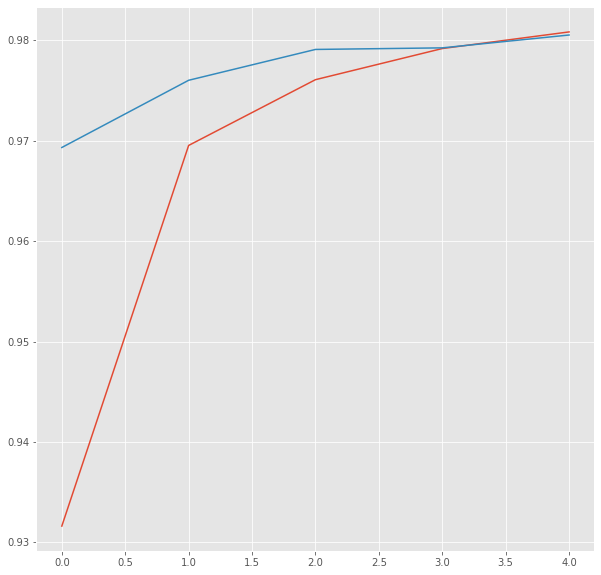

In [7]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

In [9]:
# Evaluation
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

test_pred = model.predict(X_te, verbose=1)
d_index_to_tags = {i: w for w, i in d_tags_to_index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(d_index_to_tags[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

752/752 [==============================] - 3s 5ms/step
F1-score: 54.8%
           precision    recall  f1-score   support

      ADR       0.51      0.53      0.52       523
     Drug       0.80      0.72      0.76       195
  Disease       0.00      0.00      0.00        32
  Symptom       0.00      0.00      0.00        29
  Finding       0.00      0.00      0.00        34

micro avg       0.59      0.52      0.55       813
macro avg       0.52      0.52      0.52       813



In [16]:
# Trying some predictions
idx = 120
p = model.predict(np.array([X_te[idx]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[idx], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[idx], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(l_words[w-1], l_tags[t], l_tags[pred]))

Word           ||True ||Pred
loss           : B-ADR B-ADR
of             : I-ADR I-ADR
muscel         : I-ADR I-ADR
strength       : I-ADR I-ADR
,              : O     O
vertigo        : B-ADR B-ADR
caused         : O     O
by             : O     O
cramping       : B-ADR B-ADR
neck           : I-ADR I-ADR
muscels        : I-ADR I-ADR
,              : O     O
loss           : B-ADR B-ADR
of             : I-ADR I-ADR
sexual         : I-ADR I-ADR
drive          : I-ADR I-ADR
,              : O     O
hair           : O     B-ADR
,              : O     O
short          : O     B-ADR
term           : O     I-ADR
memory         : O     I-ADR
,              : O     O
zombie         : B-ADR B-ADR
like           : I-ADR I-ADR
doped          : I-ADR I-ADR
up             : I-ADR I-ADR
state          : I-ADR I-ADR
,              : O     O
halucinations  : B-ADR B-ADR
during         : I-ADR O
day            : I-ADR O
,              : O     O
unable         : B-ADR B-ADR
to             : I-ADR I-ADR


In [22]:
# Prediction on new sentence
test_sentence = ["I", "was", "suffering", "with", "chronicle", "headaches", "took",
                 "crocin", "for", "relieving", "pain"]
x_test_sent = pad_sequences(sequences=[[d_words_to_index.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=n_max_seq_size)
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}:{}".format("Word", "Prediction"))
print("="*26)
for w, pred in zip(test_sentence, p[0]):
    print("{:15}:  {:5}".format(w, l_tags[pred]))

Word           :Prediction
I              :  O    
was            :  O    
suffering      :  O    
with           :  O    
chronicle      :  B-Drug
headaches      :  B-ADR
took           :  O    
crocin         :  B-Drug
for            :  O    
relieving      :  B-ADR
pain           :  I-ADR
